# Forecasting

In the previous workshop we learned how to perform exploratory data analysis in python for our time series data, with a view to building time series models for forecasting. In this workshop we will explore the different types of time series model, how to use, interpret and evaluate them as well as look at how we can make future forecasts.

We will still be using the Ecuadorian store sales data from before.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sales=pd.read_csv('store_sales.csv')
sales.head()

,Date,family,sales,onpromotion
0,01/01/2013,AUTOMOTIVE,0.0,0
1,01/01/2013,BABY CARE,0.0,0
2,01/01/2013,BEAUTY,0.0,0
3,01/01/2013,BEVERAGES,0.0,0
4,01/01/2013,BOOKS,0.0,0


## Practice

Before we start making any time series forecasting models, the data needs to be in the correct format. Complete these steps to prepare the data:

<ol>
    <li> Transform the <i>Date</i> column to datetime and set it as the index </li>
    <li> Group the data by week and call it <code>sales_by_week</code></li>
    <li> Make a plot that shows the trend and seasonality in the data </li>
    <li> Calculate and plot a rolling average of 4 weeks </li>
    <li> Use a detrending technique to show the data without a trend </li>
    <li> Explore the autocorrelation and partial autocorrelation of the data up to 52 lags </li>
    <li> Check the last data point- why do you think it is so low? Remove this data point from the data. </li>
</ol>

In [ ]:
#A:

## Train Test Split

When building models it is important that we are able to test and evaluate them, so like before we need to split between a training and testing set. This time however, we can't just use `train_test_split()` because this randommly assigns data into the two sets, whereas we need it in chronological order. To get round this, we simply split the data on dates. 

A logical way of doing this, for our data, would be to hold back the final year's data as a testing set and using everything else for training. If you do not have a complete years worth of data, you could take the first 70% of the data as your train set and keep the rest back for testing (if you do choose to do this, both sets need to be integer sized).

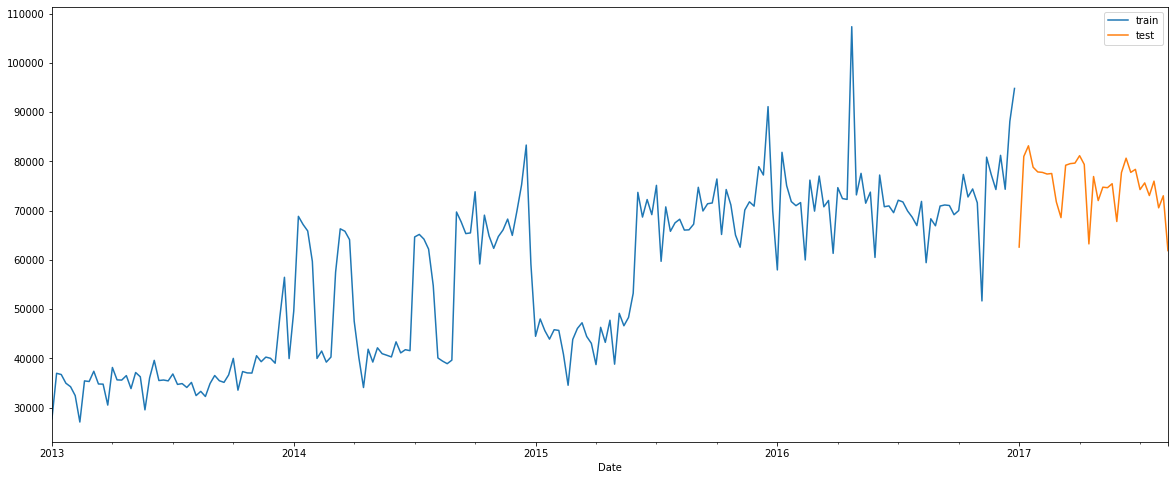

In [11]:
train=sales_by_week['2013':'2016']
test=sales_by_week['2017']

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test.sales.plot(ax=ax,label='test')
plt.legend()
plt.show()

By creating a test set we can evaluate the accuracy of any forecasting models, and we do this by calculating the error. 

The error being the difference between true and forecasted value on average. Good measures for this are <b>root mean squared error</b> and <b>mean absolute error</b>.

Now we have the information needed to set up a model, let's go about building some!

Like with all modelling, when performing times series analysis you will want to try a few of these techniques to see which is best.

## Baseline models

### Naive forecasting

This is the simplest time series model, and not one you are likely going to find to be the best. To use it, we take the last observed value and use it as our prediction- this is called naive modelling.

It is only going to be accurate if the data you are using is stationary and you are confident it will remain that way. However, it does have a useful application- a baseline. 

Essentially, naive forecasting is predicting things stay the exact same from the last observed data point, if any forecast model you build predicts that performance (i.e. sales, demand, expected customers) is worse than this, you know that there is a problem which requires addressing. 

<b>Advantages</b> of Naive forecasting:

<ul>
    <li> Simple to use </li>
    <li> Provides a baseline to compare other models against </li>
</ul>

<b> Disadvantages</b> of Naive forecasting:

<ul>
    <li> Unless data is stationary, unlikely to be accurate </li>
    <li> Cannot handle trends or seasonality </li>
</ul>

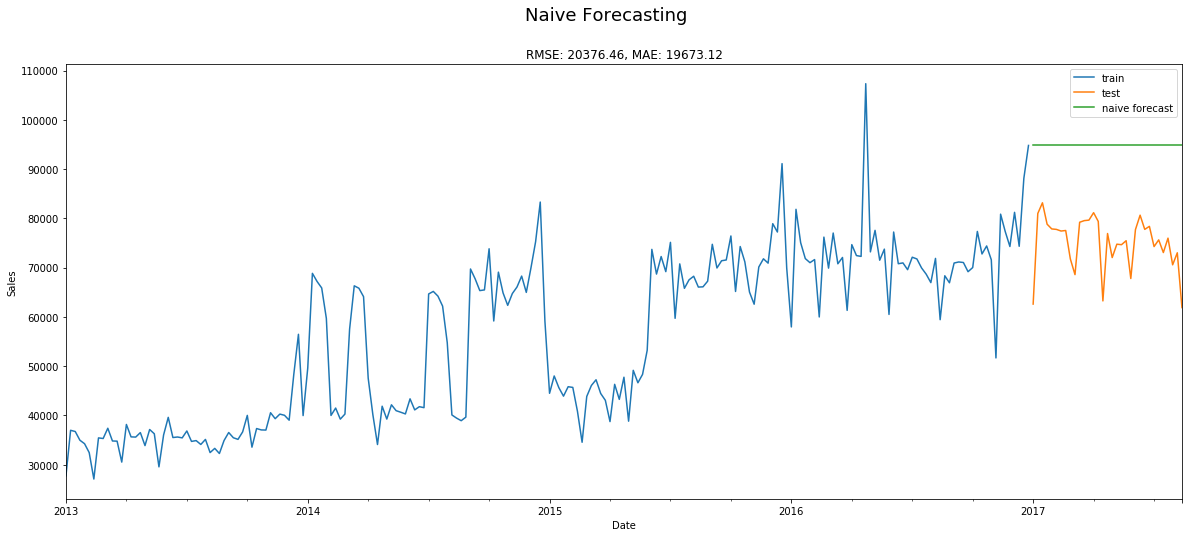

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

last_value=train.iloc[-1,0] # identify last observed value

test_naive=test.copy() # create test set for this example
test_naive['predicted']=last_value # for each observation in test set, assign forecast prediction of last_value

# calculate errors and round to 2 d.p
rmse_naive=round(np.sqrt(mean_squared_error(test_naive.sales,test_naive.predicted)),2)
mae_naive=round(mean_absolute_error(test_naive.sales,test_naive.predicted),2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_naive.sales.plot(ax=ax,label='test')
test_naive.predicted.plot(ax=ax,label='naive forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_naive)+', MAE: '+str(mae_naive))
plt.suptitle('Naive Forecasting',fontsize=18)
plt.ylabel('Sales')
plt.show()

How would you evaluate the performance of this model?

Not great, but it does give us a baseline for us to compare against. When we build more sophisticated models, we can come back to this one and see how they compare. If they perform worse, then we know they are really bad models. 

There are other baseline models we can use, which you can find in the extra models notebook. The naive model is the simplest, which is why we have chosen to look at it.

## Practice

Create a dataframe called `sales_poultry_by_month` that aggregates the poultry sales by month. Choose a baseline model to forecast sales and calculate the error.

In [1]:
#A:

## Accounting for Trends 

With our baseline methods we were unable to account for trends or seasonality within our data, which as you would imagine, would be useful to include. Charles Holt and Peter Winter, two statisticians, were able to design some techniques which take trends and seasonality into account when making forecasts.

We have already seen a method from this family of models with the simple exponential smoothing we used earlier. 

### Holt's Linear Forecast 

If the data you are using contains an obvious trend (e.g. linear increasing, exponential, etc) then this method will take that into account. It works by identifying the trend (as we saw in the last workshop) and applying it to its forecasted predictions.

<b> Advantages</b> of Holt's linear:
<ul>
    <li> Takes into account trends within the data </li>
    <li> Can be applied to different types of trend </li>
</ul>

<b> Disadvantages</b> of Holt's linear:

<ul>
    <li> Ignores autocorrelation </li>
    <li> Ignores seasonality </li>
</ul>

When building the model we have some parameters we can include:

<ul>
    <li> <b>smoothing_level</b>- defines how strong the weighting is when using exponential smoothing, value is between 0 and 1.</li>
    <li><b>optimized</b>- finds the optimal smoothing_level if set to True (recommended)</li>
</ul>

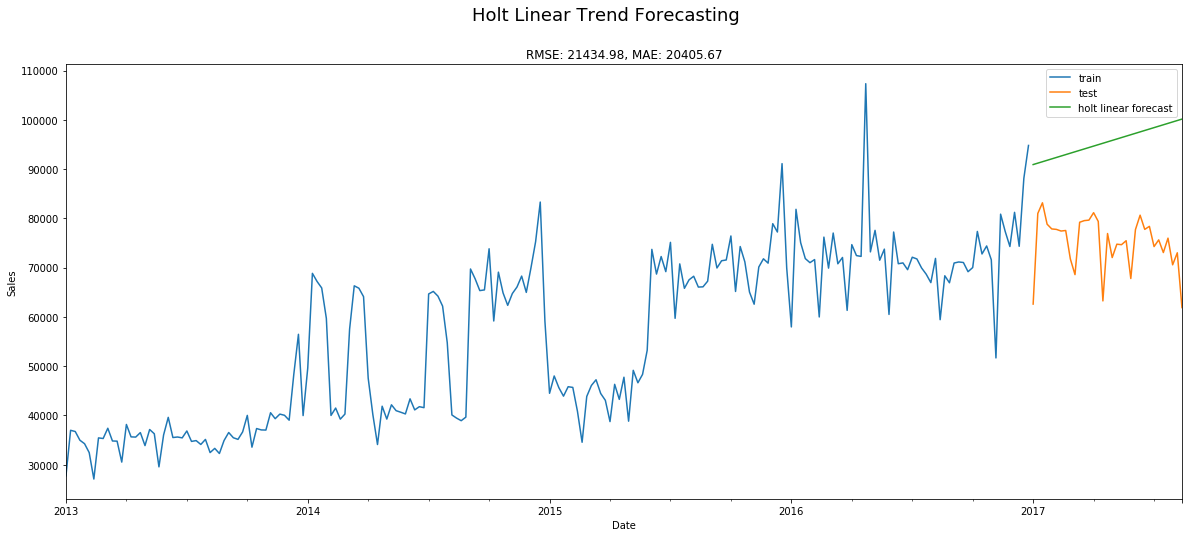

In [17]:
from statsmodels.tsa.api import Holt

# create Holt model
# If your data is showing an exponential trend (not linear), set exponential=True
holt = Holt(train.sales,exponential=False).fit(optimized=True) 


test_holt=test.copy() # create test set for this example
test_holt['predicted']=holt.forecast(len(test_holt)) # for each observation in test set, assign holt forecast

# calculate errors and round to 2 d.p
rmse_holt=round(np.sqrt(mean_squared_error(test_holt.sales,test_holt.predicted)),2)
mae_holt=round(mean_absolute_error(test_holt.sales,test_holt.predicted),2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_holt.sales.plot(ax=ax,label='test')
test_holt.predicted.plot(ax=ax,label='holt linear forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_holt)+', MAE: '+str(mae_holt))
plt.suptitle('Holt Linear Trend Forecasting',fontsize=18)
plt.ylabel('Sales')
plt.show()

As well as looking at RMSE and MAE as model evaluation tools, we can also look at the AIC and BIC:

<ul>
    <li><b>AIC</b>- Akaike Information Criterion, calculated by looking at the number of features needed to make the model and how well the model reproduces the data. The best model is the one that explains the most variation using the least number of features, which will be represented by the <b>lowest</b> AIC score</li>
    <li><b>BIC</b>- Bayesian Information Criterion, similar to AIC but reliant on the underlying data to be normally distributed. Again <b>lowest</b> BIC score is best</li>
</ul>

In [18]:
aic_holt=round(holt.aic,2)
bic_holt=round(holt.bic,2)

print('Holt Linear Trend: AIC: '+str(aic_holt))
print('Holt Linear Trend: BIC: '+str(bic_holt))

Holt Linear Trend: AIC: 3745.06
Holt Linear Trend: BIC: 3758.41


## Practice

Using your monthly poultry sales data, build a model that takes into account seasonality and trend and calculate the error.

In [2]:
#A:

### Holt's Winter's Exponential Smoothing Forecast 

The problem with the previous approach was that it did not account for seasonality. If you do have seasonality within your data, then you can use Holt Winter's method instead- also sometimes called triple exponential smoothing. 

<b> Advantages</b> of Holt Winter's Exponential Smoothing:
<ul>
    <li> Takes into account trends and seasonality within the data </li>
    <li> Can be applied to different types of trend </li>
</ul>

<b> Disadvantages</b> of Holt Winter's Exponential Smoothing:

<ul>
    <li> Ignores autocorrelation </li>
</ul>

When building the model we have some parameters we can include:

For `ExponentialSmoothing()`:

<ul>
    <li> <b> seasonal_period </b> - how many observations make up a seasonal cycle (i.e. monthly data will likely be 12, daily data likely 7, quarterly data likely 4) </li>
    <li> <b> trend </b> - What type of trend it is ('add' for linear, 'mul' for exponential) </li>
    <li> <b> seasonal </b> - What type the seasonal trend is ('add' for linear, 'mul' for exponential)</li>
</ul>

For `.fit()`:

<ul>
    <li> <b>smoothing_level</b>- defines how strong the weighting is when using exponential smoothing, value is between 0 and 1.</li>
    <li><b>optimized</b>- finds the optimal smoothing_level if set to True (recommended)</li>
</ul>

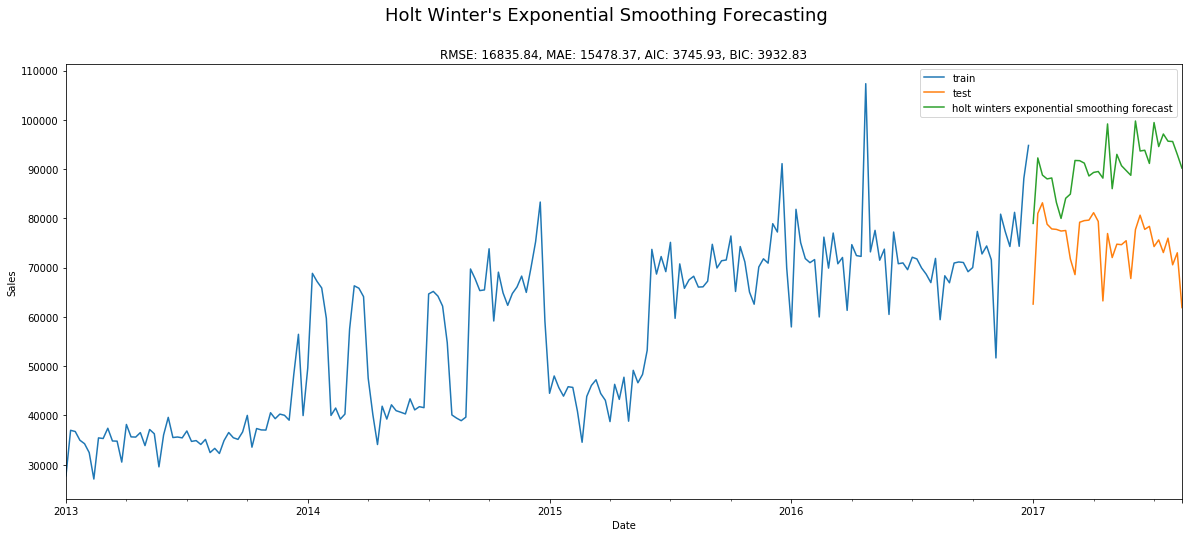

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing

# create Holt Winter's model (as weekly data, set seasonal period to 52 with linear trend)
hwes = ExponentialSmoothing(train.sales,seasonal_periods=52 ,trend='add', seasonal='add').fit(optimized=True)

test_hwes=test.copy() # create test set for this example
test_hwes['predicted']=hwes.forecast(len(test_hwes)) # for each observation in test set, assign holt winter's forecast

# calculate errors and round to 2 d.p
rmse_hwes=round(np.sqrt(mean_squared_error(test_hwes.sales,test_hwes.predicted)),2)
mae_hwes=round(mean_absolute_error(test_hwes.sales,test_hwes.predicted),2)
aic_hwes=round(hwes.aic,2)
bic_hwes=round(hwes.bic,2)

fig, ax = plt.subplots(figsize=(20,8))
train.sales.plot(ax=ax,label='train')
test_hwes.sales.plot(ax=ax,label='test')
test_hwes.predicted.plot(ax=ax,label='holt winters exponential smoothing forecast')
plt.legend()
plt.title('RMSE: '+str(rmse_hwes)+', MAE: '+str(mae_hwes)+', AIC: '+str(aic_hwes)+', BIC: '+str(bic_hwes))
plt.suptitle("Holt Winter's Exponential Smoothing Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

These two methods are more sophisticated than the baseline methods as they account for trend and seasonality. You can see in both they assume the trend will continue. Using a Holt-Winter's approach is perfectly reasonable, but they do not account for autocorrelation between data points. 

Let's compare the two methods against each other:

In [21]:
holt_metric=pd.DataFrame({'Model':['Holt Linear','Holt Winter Exponential Smoothing'],
                           'RMSE':[rmse_holt,rmse_hwes],
                           'MAE':[mae_holt,mae_hwes],
                           'AIC':[aic_holt,aic_hwes],
                           'BIC':[bic_holt,bic_hwes]})
holt_metric

,Model,RMSE,MAE,AIC,BIC
0,Holt Linear,21434.98,20405.67,3745.06,3758.41
1,Holt Winter Exponential Smoothing,16835.84,15478.37,3745.93,3932.83


## Practice

Using your monthly poultry sales data, build a model that takes into account seasonality and trend and calculate the error.

In [3]:
#A:

So far we have looked at some interesting forecasting models, but there exists a whole family called AutoRegressive models that we do not have time to look into today. In the module 10 folder, you will find a notebook called AutoRegressive models that you can explore.

These models are often more powerful than what we have seen so far, and are easily customisable. However, they do require a lot of preparation which you will be asked to justify in your EPA (if you use one). If you do use an AutoRegressive model, make sure you have researched fully how to prepare so you can explain how you built your model effectively.

## Deploying Your Model

What do you do once you have built your forecasting model?

Do you just sit on it, happy with the insights you have already found?

Or do you deploy it, forecasting beyond the data to predict what might happen next?

It depends on what you want to do with the data. Time series analysis is a useful tool for examining what has happened in the past to prompt investigation about why it happened. It is also about predicting the future!

The models you built in the workshop were trained on a subset of the data, and tested with the rest to see how accurate they were. We are now going to take the last model we built and forecast <i>beyond</i> the data to predict what might happen next...

But how do we choose which one is best?

### AIC v.s. RMSE
AIC and RMSE are inter-related but they represent different objectives in choosing the best model.

RMSE/MAE are measures of error and disregards the "complexity" of the model. Optimizing for RMSE/MAE can give you accurate results, but could lead to overly complex model that captures too much noise in the data, otherwise known as overfitting.

This is where AIC and their relative BIC comes in. They take the error term and add a penalty related to the number of predictors used in the model, such that more complex models are less favorable and allows you to strike a balance between a complex but accurate model, vs a simpler but still reasonably accurate model.

<b>It ultimately comes down to the purpose of your model. If having the most accurate prediction matters then you might simply look at RMSE/MAE, but if you need a model that is more interpretable/explainable then you might want to consider AIC which better balances complexity and accuracy.</b>

Let's select Holt Winter Exponential Smoothing as our best model:

In [42]:
holt_metric

,Model,RMSE,MAE,AIC,BIC
0,Holt Linear,21434.98,20405.67,3745.06,3758.41
1,Holt Winter Exponential Smoothing,16835.84,15478.37,3745.93,3932.83


### Refitting the model to the whole dataset 

Use <b>original sales_by_week data <span style="color: red;">not</span> the train dataset</b> as we want to give our prefered model all availble data and to forecast forwards from the most recent availble data point (most recent data of train dataset is ~ a year older than the most recent data point availible. 

We split the data into training and testing sets purely for the purpose of testing the model out. Once you are happy, rebuild it using all your data to make future predictions.


In [49]:
hwes = ExponentialSmoothing(sales_by_week.sales,seasonal_periods=12 ,trend='add', seasonal='add').fit(optimized=True)
forecasts=hwes.predict(start=test_hwes.index[-1],end='2018-12-10')# the start date is the last observation in the data
print(forecasts)

2017-08-13    70131.587105
2017-08-20    68631.424221
2017-08-27    71312.484973
2017-09-03    70675.923365
2017-09-10    70990.602606
                  ...     
2018-11-18    79894.964376
2018-11-25    78276.465466
2018-12-02    76528.141449
2018-12-09    77351.531988
2018-12-16    78792.378966
Freq: W-SUN, Length: 71, dtype: float64


Let's plot this with our data:

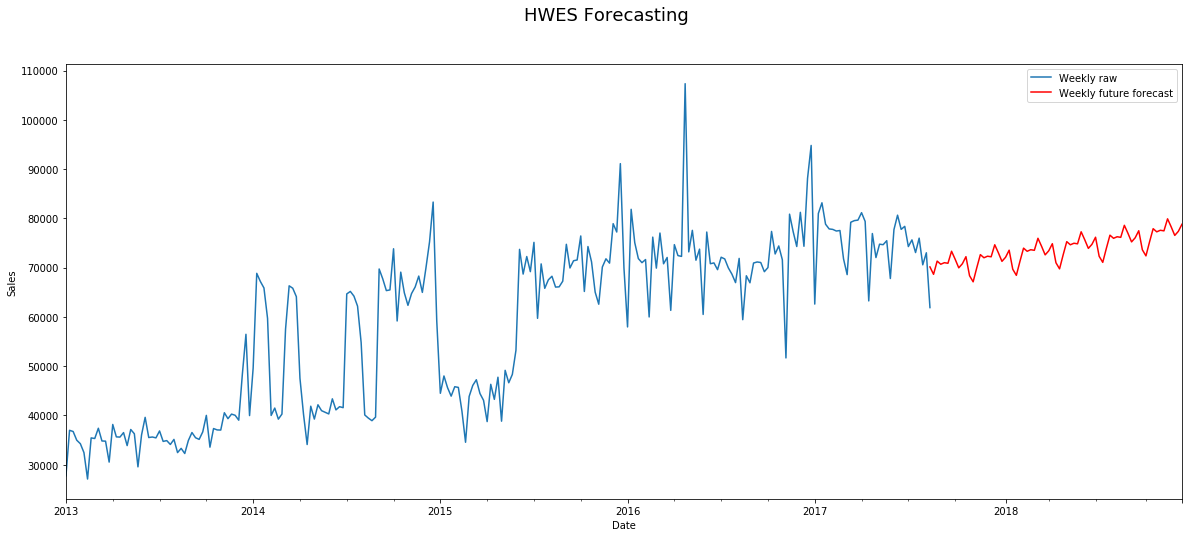

In [51]:
fig, ax = plt.subplots(figsize=(20,8))
sales_by_week.sales.plot(ax=ax,label='Weekly raw')
forecasts.plot(ax= ax, label = 'Weekly future forecast', color = 'red')

plt.legend()
plt.suptitle("HWES Forecasting",fontsize=18)
plt.ylabel('Sales')
plt.show()

Now we can see what the model thinks will happen with sales in the future. Now, we always need to take this with a touch of scepticism- this is a prediction. Our confidence comes from how well the model performed during the train-test-split evaluation.

You should never take these forecasts as fact. Instead you should use them to say, 'based on historical trends, this is what we think is going to happen.' You can then set the forecasted values as targets or theoretical benchmarks which you can compare your actual values to as they appear. Remember, the further in the future a forecast is, the more unreliable it is.

Forecasting is not a one-and-done process, it is a good plan to rebuild the model everytime new data comes in to see if that changes the forecast.

## Practice

Deploy your model for the monthly poultry sales data, using the entire dataset

In [ ]:
#A:

## Saving our models

So far you have been building models in one notebook, and to reuse it you have to rerun all the code again. Wouldn't it be simpler to just save it?

You can, using the `joblib` library:

In [34]:
import joblib

To use joblib you just need to give the model a name:

In [35]:
filename='HWES_model.sav'
joblib.dump(hwes,filename) #this line saves the model (called hwes when we built it) and gives it the filename

['HWES_model.sav']

Check the folder this notebook is saved in, you should now see the file there (by the way, this works for any type of model, not just forecasting).

If we want to load the model, we just need to call the filename:

In [36]:
load=joblib.load(filename)
load

We can now use the model in the same way as before:

In [37]:
load.predict(start=test_hwes.index[-1],end='2018-12-10')

2017-08-13     90179.701210
2017-08-20     92446.444505
2017-08-27     91515.899801
2017-09-03    102604.896027
2017-09-10     99693.824038
                  ...      
2018-11-18    123437.947505
2018-11-25    121274.341110
2018-12-02    125786.807497
2018-12-09    127108.961604
2018-12-16    139354.918347
Freq: W-SUN, Length: 71, dtype: float64

Saving our models in this way allows us to transfer them between different users, or even do something really fancy, like incorporate them into a pipeline which takes data -> makes a forecast -> displays it in a dashboard.